# 5.2.1 Tunning MLP Structured Data Regression

In [ ]:
!pip install -r https://raw.githubusercontent.com/datamllab/automl-in-action-notebooks/master/requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 41.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.1/590.1 kB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.7 MB/s

In [ ]:
import tensorflow as tf
import autokeras as ak

Using TensorFlow backend


### Tunning MLP for structured-data regression (Normalization + DenseBlock)

In [ ]:
input_node = ak.StructuredDataInput()
output_node = ak.Normalization()(input_node)
output_node = ak.DenseBlock(use_batchnorm=False, dropout=0.0)(output_node)
output_node = ak.RegressionHead(dropout=0.0)(output_node)
auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, max_trials=10, overwrite=True, seed=42
)

In [ ]:
from sklearn.datasets import fetch_california_housing

house_dataset = fetch_california_housing()

# Import pandas package to format the data
import pandas as pd

# Extract features with their names into the dataframe format
data = pd.DataFrame(house_dataset.data, columns=house_dataset.feature_names)

# Extract target with their names into a pd.Series object with name MEDV
target = pd.Series(house_dataset.target, name="MEDV")

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(
    data, target, test_size=0.2, random_state=42
)


auto_model.fit(train_data, train_targets, batch_size=1024, epochs=150)


Trial 10 Complete [00h 01m 20s]
val_loss: 0.5836808085441589

Best val_loss So Far: 0.28327369689941406
Total elapsed time: 00h 08m 09s
Epoch 1/150
17/17 [==============================] - 1s 8ms/step - loss: 2.2361 - mean_squared_error: 2.2361
Epoch 2/150
17/17 [==============================] - 0s 8ms/step - loss: 0.8058 - mean_squared_error: 0.8058
Epoch 3/150
17/17 [==============================] - 0s 10ms/step - loss: 0.6130 - mean_squared_error: 0.6130
Epoch 4/150
17/17 [==============================] - 0s 8ms/step - loss: 0.4994 - mean_squared_error: 0.4994
Epoch 5/150
17/17 [==============================] - 0s 9ms/step - loss: 0.4382 - mean_squared_error: 0.4382
Epoch 6/150
17/17 [==============================] - 0s 9ms/step - loss: 0.4086 - mean_squared_error: 0.4086
Epoch 7/150
17/17 [==============================] - 0s 9ms/step - loss: 0.3893 - mean_squared_error: 0.3893
Epoch 8/150
17/17 [==============================] - 0s 8ms/step - loss: 0.3765 - mean_squared_error

### Visualize the Best Pipeline

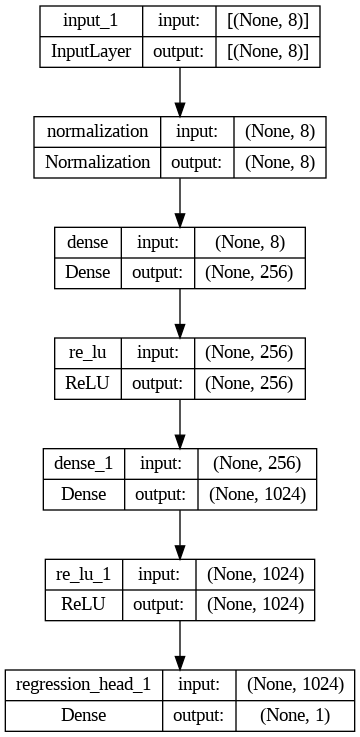

In [ ]:
best_model = auto_model.export_model()
tf.keras.utils.plot_model(
    best_model, show_shapes=True, expand_nested=True
) # rankdir = 'LR


### Evaluate Best Pipeline

In [ ]:
test_loss, test_acc = auto_model.evaluate(test_data, test_targets, verbose=0)
print("Test Accuracy: ", test_acc)

Test Accuracy:  0.27266019582748413


### Show Best Trial

Results summary
Results in ./auto_model
Showing 1 best trials
Trial summary
Hyperparameters:
dense_block_1/num_layers: 2
dense_block_1/units_0: 256
dense_block_1/units_1: 1024
optimizer: adam
learning_rate: 0.001
Score: 0.28327369689941406


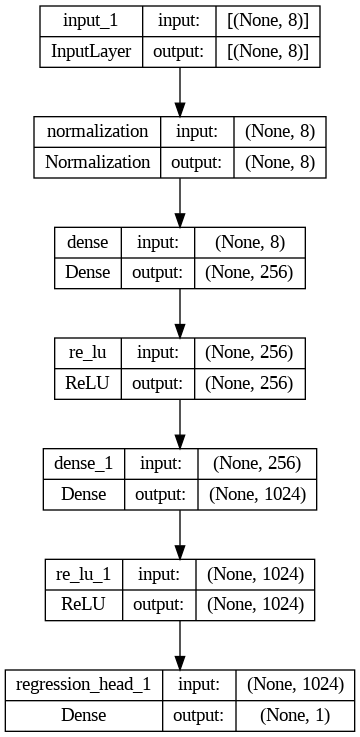

In [ ]:
auto_model.tuner.results_summary(num_trials=1)
best_model = auto_model.export_model()
tf.keras.utils.plot_model(best_model, show_shapes=True, expand_nested=True)

In [ ]:
from tensorflow import keras

best_model.save('saved_model')
best_model = keras.models.load_model('saved_model')

### Customize the search space for tuning MLP  

In [ ]:
from keras_tuner.engine import hyperparameters as hp

input_node = ak.StructuredDataInput()
output_node = ak.Normalization()(input_node)
output_node = ak.DenseBlock(

    num_layers = 1,
    num_units = hp.Choice("num_units", [128, 256, 512, 1024]),
    use_batchnorm = True,
    dropout = 0.0,


)(output_node)

output_node = ak.RegressionHead()(output_node)
auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, max_trials=10, overwrite=True, seed=42
)

auto_model.fit(train_data, train_targets, batch_size=1024, epochs=150)

Trial 10 Complete [00h 00m 52s]
val_loss: 0.4353950023651123

Best val_loss So Far: 0.38629937171936035
Total elapsed time: 00h 05m 38s
Epoch 1/150
17/17 [==============================] - 1s 8ms/step - loss: 3.1084 - mean_squared_error: 3.1084
Epoch 2/150
17/17 [==============================] - 0s 8ms/step - loss: 1.0638 - mean_squared_error: 1.0638
Epoch 3/150
17/17 [==============================] - 0s 9ms/step - loss: 0.8324 - mean_squared_error: 0.8324
Epoch 4/150
17/17 [==============================] - 0s 9ms/step - loss: 0.7199 - mean_squared_error: 0.7199
Epoch 5/150
17/17 [==============================] - 0s 9ms/step - loss: 0.6637 - mean_squared_error: 0.6637
Epoch 6/150
17/17 [==============================] - 0s 8ms/step - loss: 0.6208 - mean_squared_error: 0.6208
Epoch 7/150
17/17 [==============================] - 0s 9ms/step - loss: 0.5886 - mean_squared_error: 0.5886
Epoch 8/150
17/17 [==============================] - 0s 9ms/step - loss: 0.5648 - mean_squared_error:

### Display the Best Pipeline

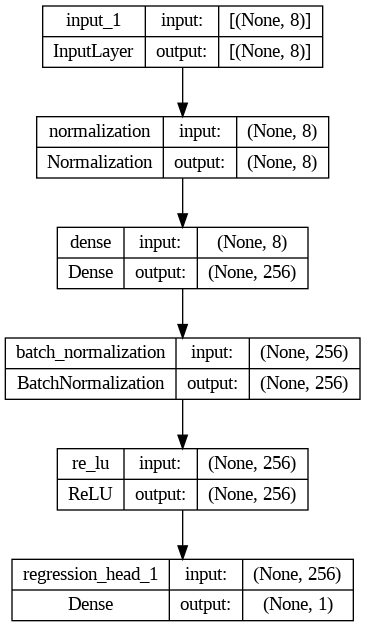

In [ ]:
best_model = auto_model.export_model()

tf.keras.utils.plot_model(
    best_model, show_shapes=True, expand_nested=True
) # rankdir = "LR"

In [ ]:
test_loss, test_acc = auto_model.evaluate(test_data, test_targets, verbose=0)
print("Test accuracy: ", test_acc)



Test accuracy:  0.38204076886177063


In [ ]:
auto_model.tuner.results_summary(num_trials=1)


Results summary
Results in ./auto_model
Showing 1 best trials
Trial summary
Hyperparameters:
dense_block_1/units_0: 256
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.001
Score: 0.38629937171936035


In [ ]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               2304      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                                 
 regression_head_1 (Dense)   (None, 1)                 257   

# 5.2.2 Tuning CNN Image Classification

### Load MNIST DataSet

In [ ]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Training image shape: ", x_train.shape) # (60000, 28, 28)
print("Training label shape: ", y_train.shape) # (60000,)
print("First five training labels: ", y_train[:5]) # array([5 0 4 1 9], dtype=uint8)

11490434/11490434 [==============================] - 0s 0us/step
Training image shape:  (60000, 28, 28)
Training label shape:  (60000,)
First five training labels:  [5 0 4 1 9]


### Run the Image Classifier

In [ ]:
from kerastuner.engine import hyperparameters as hp

input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ConvBlock(
    num_blocks=2, max_pooling=True, separable=False, dropout=0.0
)(output_node)

output_node = ak.ClassificationHead(dropout=0.0)(output_node)

auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, max_trials=10, overwrite=True, seed=42
)

# Use the first 100 training samples as quick demo.
# You may run with the full dataset, but expect a longer training time.
auto_model.fit(x_train[:100], y_train[:100], epochs=3)
test_loss, test_acc = auto_model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: ", test_acc)

Trial 10 Complete [00h 00m 02s]
val_loss: 2.257382869720459

Best val_loss So Far: 1.113058090209961
Total elapsed time: 00h 00m 31s
Epoch 1/3
4/4 [==============================] - 1s 24ms/step - loss: 2.2271 - accuracy: 0.1900
Epoch 2/3
4/4 [==============================] - 0s 8ms/step - loss: 1.7806 - accuracy: 0.5700
Epoch 3/3
4/4 [==============================] - 0s 8ms/step - loss: 1.3247 - accuracy: 0.7200


Test accuracy:  0.5698000192642212


### Get summarized results during the tunning process (return the 10 best models if existed)

In [ ]:
auto_model.tuner.results_summary(1)

Results summary
Results in ./auto_model
Showing 1 best trials
Trial summary
Hyperparameters:
conv_block_1/kernel_size: 3
conv_block_1/num_layers: 1
conv_block_1/filters_0_0: 512
conv_block_1/filters_0_1: 256
conv_block_1/filters_1_0: 32
conv_block_1/filters_1_1: 256
classification_head_1/spatial_reduction_1/reduction_type: flatten
optimizer: adam
learning_rate: 0.001
Score: 1.113058090209961


### Retrieve & Display the best model

In [ ]:
best_model = auto_model.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 28, 28)           0         
 t32)                                                            
                                                                 
 expand_last_dim (ExpandLast  (None, 28, 28, 1)        0         
 Dim)                                                            
                                                                 
 normalization (Normalizatio  (None, 28, 28, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 512)       5120      
                                                             

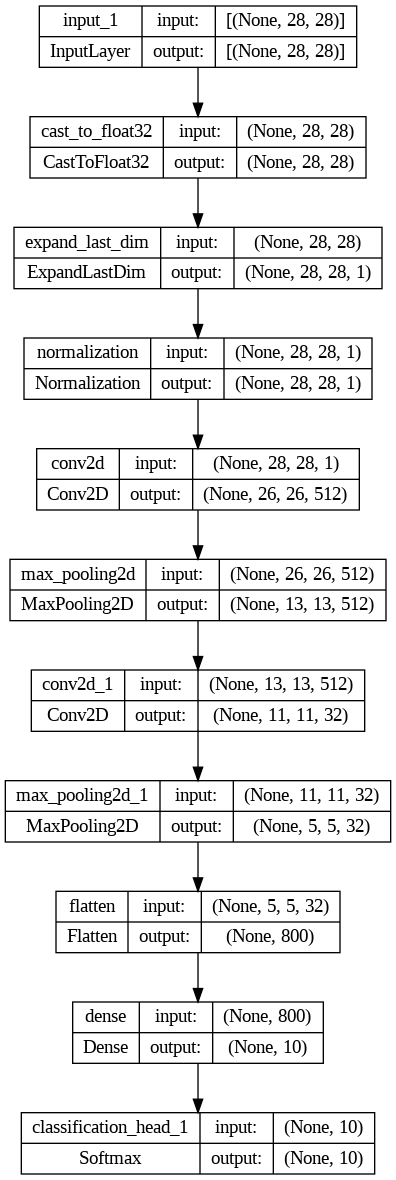

In [ ]:
tf.keras.utils.plot_model(best_model, show_shapes=True, expand_nested=True)

### Predict with the Best Model

In [ ]:
predicted_y = auto_model.predict(x_test)
print(predicted_y)

313/313 [==============================] - 1s 3ms/step
[['7']
 ['6']
 ['1']
 ...
 ['9']
 ['8']
 ['6']]


# 5.3.1 Automated Pipeline Search Image Model Selection

## Load MNIST dataset

In [ ]:
from tensorflow.keras.datasets import cifar10, fashion_mnist, mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Training image shape: ", x_train.shape) # (60000, 28, 28)
print("Training label shape: ", y_train.shape) # (60000,)
print("First five training labels: ", y_train[:5])

11490434/11490434 [==============================] - 1s 0us/step
Training image shape:  (60000, 28, 28)
Training label shape:  (60000,)
First five training labels:  [5 0 4 1 9]


## ResNetBlock

In [ ]:
import timeit
import autokeras as ak

input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ResNetBlock()(output_node)
output_node = ak.ClassificationHead()(output_node)

resnet_auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, max_trials=3, overwrite=True, seed=42
)

start_time = timeit.default_timer()

# To save time, using the first 100 training samples for 1 epoch with batch_size=8 as a quick demo.
resnet_auto_model.fit(x_train[:100], y_train[:100], epochs=1, batch_size=8)
stop_time = timeit.default_timer()
print("Total time: {time} seconds.".format(time=round(stop_time - start_time, 2)))

Trial 3 Complete [00h 00m 14s]
val_loss: 1159.6834716796875

Best val_loss So Far: 1159.6834716796875
Total elapsed time: 00h 00m 59s
13/13 [==============================] - 11s 141ms/step - loss: 49.5566 - accuracy: 0.2000


Total time: 113.75 seconds.


### Get the summarized results during the tuning process

In [ ]:
resnet_auto_model.tuner.results_summary()

Results summary
Results in ./auto_model
Showing 10 best trials
Trial summary
Hyperparameters:
res_net_block_1/pretrained: False
res_net_block_1/version: resnet50
res_net_block_1/imagenet_size: True
classification_head_1/spatial_reduction_1/reduction_type: flatten
classification_head_1/dropout: 0.25
optimizer: adam
learning_rate: 0.001
Score: 1159.6834716796875
Trial summary
Hyperparameters:
res_net_block_1/pretrained: False
res_net_block_1/version: resnet50
res_net_block_1/imagenet_size: True
classification_head_1/spatial_reduction_1/reduction_type: flatten
classification_head_1/dropout: 0
optimizer: adam
learning_rate: 0.001
Score: 49924.64453125
Trial summary
Hyperparameters:
res_net_block_1/pretrained: False
res_net_block_1/version: resnet50
res_net_block_1/imagenet_size: True
classification_head_1/spatial_reduction_1/reduction_type: flatten
classification_head_1/dropout: 0
optimizer: adam
learning_rate: 0.1
Score: 3.354955536777761e+33


### Display Best Model

In [ ]:
best_resnet_model = resnet_auto_model.export_model()
best_resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 cast_to_float32 (CastToFloat32  (None, 28, 28)      0           ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 expand_last_dim (ExpandLastDim  (None, 28, 28, 1)   0           ['cast_to_float32[0][0]']        
 )                                                                                                
                                                                                              

### Evaluate the best resnet model on the test data

In [ ]:
# Only evaluating the first 100 samples as a quick demo

test_loss, test_acc = resnet_auto_model.evaluate(
    x_test[:100], y_test[:100], batch_size=8
)

print("Accuracy: {accuracy}%".format(accuracy=round(test_acc * 100, 2)))

13/13 [==============================] - 2s 37ms/step - loss: 78077.0781 - accuracy: 0.0800
Accuracy: 8.0%


## Xception Block

In [ ]:
import timeit

input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.XceptionBlock()(output_node)
output_node = ak.ClassificationHead()(output_node)

xception_auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, max_trials=3, overwrite=True, seed=42
)

start_time = timeit.default_timer()

# To save time, using 100 samples only

xception_auto_model.fit(x_train[:100], y_train[:100], epochs=1, batch_size=8)

stop_time = timeit.default_timer()

print("Total time: {time} seconds. ".format(time=round(stop_time - start_time, 2)))

Trial 3 Complete [00h 00m 20s]
val_loss: 2.30249285697937

Best val_loss So Far: 2.3004753589630127
Total elapsed time: 00h 01m 07s
13/13 [==============================] - 12s 180ms/step - loss: 3.3405 - accuracy: 0.2600


Total time: 135.07 seconds. 


### Display the Best Xception Model

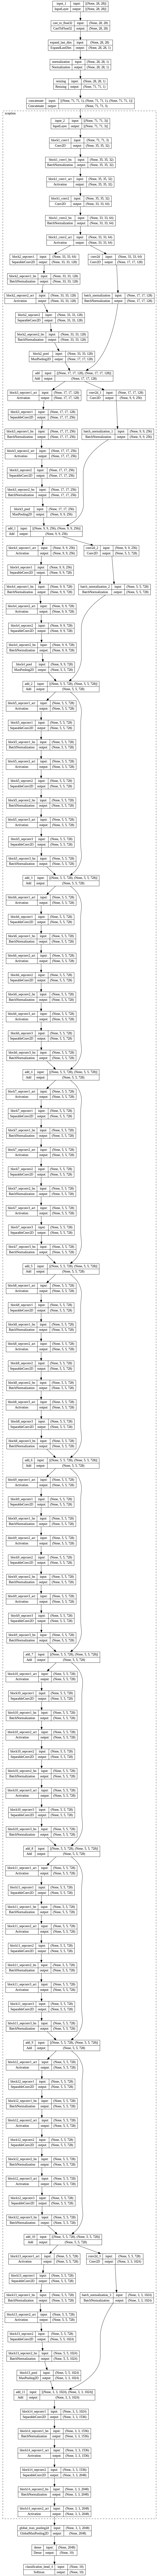

In [ ]:
best_xception_model = xception_auto_model.export_model()
tf.keras.utils.plot_model(
    best_xception_model, show_shapes=True, expand_nested=True
)

In [ ]:
best_xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 cast_to_float32 (CastToFloat32  (None, 28, 28)      0           ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 expand_last_dim (ExpandLastDim  (None, 28, 28, 1)   0           ['cast_to_float32[0][0]']        
 )                                                                                                
                                                                                              

### Evaluate the best xception model on the test data

In [ ]:
test_loss, test_acc = xception_auto_model.evaluate(x_test[:100], y_test[:100])
print("Accuracy: {accuracy}%".format(accuracy=round(test_acc * 100, 2)))

4/4 [==============================] - 2s 21ms/step - loss: 2.3016 - accuracy: 0.0700
Accuracy: 7.0%


## HyperBlock for Image Classification

In [ ]:
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ImageBlock(
    # Normalize the dataset
    normalize=True,
    # Do not do data augmentation
    augment=False,

)(output_node)
output_node = ak.ClassificationHead()(output_node)

auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, max_trials=3, overwrite=True, seed=42
)

start_time = timeit.default_timer()

# To save time, using the first 100 training samples for 1 epoch with batch_size=8 as a quick demo.
auto_model.fit(x_train[:100], y_train[:100], epochs=1, batch_size=8)
stop_time = timeit.default_timer()
print("Total time: {time} seconds.".format(time=round(stop_time - start_time, 2)))

Trial 3 Complete [00h 00m 19s]
val_loss: 22478.947265625

Best val_loss So Far: 22478.947265625
Total elapsed time: 00h 01m 29s
13/13 [==============================] - 15s 195ms/step - loss: 58.6351 - accuracy: 0.1300


Total time: 152.59 seconds.


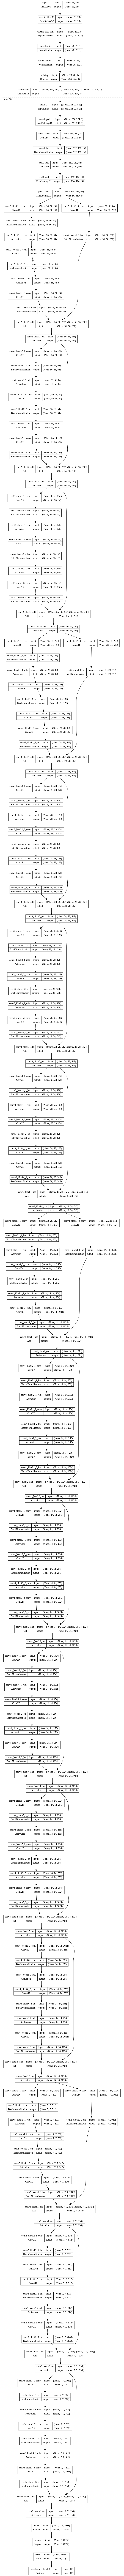

In [ ]:
best_model = auto_model.export_model()
tf.keras.utils.plot_model(
    best_model, show_shapes=True, expand_nested=True
)

In [ ]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 cast_to_float32 (CastToFloat32  (None, 28, 28)      0           ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 expand_last_dim (ExpandLastDim  (None, 28, 28, 1)   0           ['cast_to_float32[0][0]']        
 )                                                                                                
                                                                                              

In [ ]:
auto_model.tuner.results_summary(num_trials=1)

Results summary
Results in ./auto_model
Showing 1 best trials
Trial summary
Hyperparameters:
image_block_1/block_type: resnet
image_block_1/res_net_block_1/pretrained: False
image_block_1/res_net_block_1/version: resnet50
image_block_1/res_net_block_1/imagenet_size: True
classification_head_1/spatial_reduction_1/reduction_type: flatten
classification_head_1/dropout: 0.25
optimizer: adam
learning_rate: 0.001
Score: 22478.947265625


In [ ]:
test_loss, test_acc = auto_model.evaluate(x_test[:100], y_test[:100])
print("Accuracy: {accuracy}%".format(accuracy=round(test_acc * 100, 2)))

4/4 [==============================] - 3s 75ms/step - loss: 18391.7441 - accuracy: 0.0800
Accuracy: 8.0%


# 5.3.2 Automated Pipeline Search Image Preprocessing

## Load Cifar 10 Dataset

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Training image shape: ", x_train.shape) # (60000, 28, 28)
print("Training label shape: ", y_train.shape) # (60000,)
print("First five training labels: ", y_train[:5])

170498071/170498071 [==============================] - 6s 0us/step
Training image shape:  (50000, 32, 32, 3)
Training label shape:  (50000, 1)
First five training labels:  [[6]
 [9]
 [9]
 [4]
 [1]]


In [ ]:
airplane_automobile_indices_train = (y_train[:, 0] == 0) | (y_train[:, 0] == 1)
airplane_automobile_indices_test = (y_test[:, 0] == 0) | (y_test[:, 0] == 1)

x_train, y_train = (
    x_train[airplane_automobile_indices_train],
    y_train[airplane_automobile_indices_train],
)

x_test, y_test = (
    x_test[airplane_automobile_indices_test],
    y_test[airplane_automobile_indices_test],
)

print("Training image shape: ", x_train.shape) # (60000, 28, 28)
print("Training label shape: ", y_train.shape) # (60000,)
print("First five training labels: ", y_train[:5])

Training image shape:  (10000, 32, 32, 3)
Training label shape:  (10000, 1)
First five training labels:  [[1]
 [1]
 [0]
 [0]
 [1]]


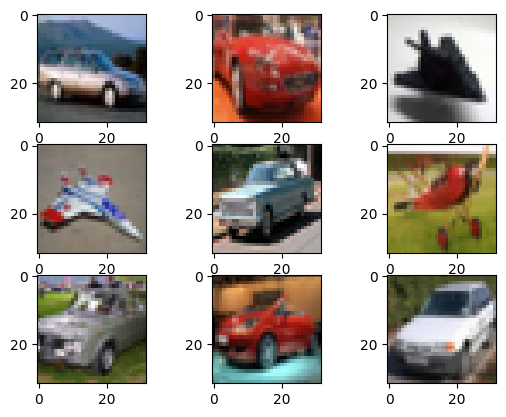

In [ ]:
# plot first few images
import matplotlib.pyplot as plt

for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(x_train[i])

# show the figure
plt.show()


## Jointly selecting image augmentation and normalization methods for ResNet models

In [ ]:
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ImageAugmentation()(output_node) # horizontal_flip = False
output_node = ak.ResNetBlock(version="v2")(output_node)
output_node = ak.ClassificationHead(dropout=0.0)(output_node)

clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=10
)

clf.fit(x_train, y_train, epochs=10)

Trial 7 Complete [00h 42m 16s]
val_loss: 1.0459315776824951

Best val_loss So Far: 0.14681193232536316
Total elapsed time: 01h 37m 38s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
0                 |0                 |image_augmentation_1/translation_factor
True              |True              |image_augmentation_1/horizontal_flip
False             |False             |image_augmentation_1/vertical_flip
0                 |0                 |image_augmentation_1/rotation_factor
0                 |0                 |image_augmentation_1/zoom_factor
0                 |0                 |image_augmentation_1/contrast_factor
True              |False             |res_net_block_2/pretrained
resnet152_v2      |resnet152_v2      |res_net_block_2/version
True              |True              |res_net_block_2/imagenet_size
global_avg        |global_avg        |classification_head_1/spatial_reduction_1/reduction_type
adam              |adam              |optimizer


KeyboardInterrupt: ignored

In [ ]:
import timeit

input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # do not specify if we want to use normalization and let it to search automatically
    normalize = None,

    # do not specify if we want to use data augmentation method and let it to search automatically
    augment = None,

    # Only search resnet architecture
    block_type = 'resnet',

)(input_node)
output_node = ak.ClassificationHead(dropout=0.0)(output_node)

auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=3
)

start_time = timeit.default_timer()

auto_model.fit(x_train, y_train, epochs=10, batch_size=4)

stop_time = timeit.default_timer()

print("Total time {time} seconds. ".format(time=round(stop_time - start_time, 2)))





Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
False             |?                 |image_block_1/normalize
False             |?                 |image_block_1/augment
False             |?                 |image_block_1/res_net_block_1/pretrained
resnet152_v2      |?                 |image_block_1/res_net_block_1/version
False             |?                 |image_block_1/res_net_block_1/imagenet_size
flatten           |?                 |classification_head_1/spatial_reduction_1/reduction_type
adam              |?                 |optimizer
0.001             |?                 |learning_rate

Epoch 1/10
2000/2000 [==============================] - 272s 125ms/step - loss: 0.7244 - accuracy: 0.6091 - val_loss: 0.7361 - val_accuracy: 0.5050
Epoch 2/10
2000/2000 [==============================] - 238s 119ms/step - loss: 0.7234 - accuracy: 0.5824 - val_loss: 0.7308 - val_accuracy: 0.4980
Epoch 3/10
2000/2000 [==============================] - 239s 119ms/st

KeyboardInterrupt: ignored

In [ ]:
auto_model.tuner.results_summary()

In [ ]:
best_model = auto_model.export_model()
best_model.summary()

In [ ]:
test_loss, test_acc = auto_model.evaluate(x_test, y_test, verbose=0)
print("Accuracy {accuracy}%".format(accuracy=round(test_acc * 100, 2)))

# 5.4 Graph Structure AutoML Pipeline Multi Input Output

In [ ]:
!pip install -r https://raw.githubusercontent.com/datamllab/automl-in-action-notebooks/master/requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 98.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.1 MB/s

In [ ]:
import tensorflow as tf
import autokeras as ak

Using TensorFlow backend


### Load MNIST Dataset

In [ ]:
import numpy as np

num_instances = 1000

# Generate Image Data
image_data = np.random.rand(num_instances, 32, 32, 3).astype(np.float32)
image_train, image_test = image_data[:800], image_data[800:]

# Generate Structured Data
structured_data = np.random.choice(["a", "b", "c", "d", "e"], size=(num_instances, 3))
structured_train, structured_test = structured_data[:800], structured_data[800:]

# Generate classification labels of five classes
classification_target = np.random.randint(5, size=num_instances)
clf_target_train, clf_target_test = (
    classification_target[:800],
    classification_target[800:],
)

# Generate Regression Target
regression_target = np.random.rand(num_instances, 1).astype(np.float32)
reg_target_train, reg_target_test = regression_target[:800], regression_target[800:]

In [ ]:
structured_train[:5]

array([['c', 'b', 'd'],
       ['a', 'e', 'b'],
       ['d', 'e', 'd'],
       ['c', 'a', 'd'],
       ['c', 'd', 'e']], dtype='<U1')

In [ ]:
clf_target_train[:5]

array([4, 3, 3, 0, 4])

In [ ]:
reg_target_train[:5]

array([[0.66007286],
       [0.56805426],
       [0.47144264],
       [0.05395776],
       [0.4998218 ]], dtype=float32)

### Run Image Classifier

In [ ]:
import autokeras as ak

In [ ]:
input_node1 = ak.ImageInput()
branch1 = ak.Normalization()(input_node1)
branch1 = ak.ConvBlock()(branch1)

input_node2 = ak.StructuredDataInput()
branch2 = ak.CategoricalToNumerical()(input_node2)
branch2 = ak.DenseBlock()(branch2)

merge_node = ak.Merge()([branch1, branch2])
output_node1 = ak.ClassificationHead()(merge_node)
output_node2 = ak.RegressionHead()(merge_node)

auto_model = ak.AutoModel(
    inputs = [input_node1, input_node2],
    outputs = [output_node1, output_node2],
    max_trials = 3,
    overwrite=True,
    seed=42,
)

auto_model.fit(
    [image_train, structured_train],
    [clf_target_train, reg_target_train],
    epochs=3
)

Trial 3 Complete [00h 00m 04s]
val_loss: 1.692505121231079

Best val_loss So Far: 1.6911051273345947
Total elapsed time: 00h 00m 23s
Epoch 1/3
25/25 [==============================] - 2s 14ms/step - loss: 1.8205 - classification_head_1_loss: 1.6395 - regression_head_1_loss: 0.1810 - classification_head_1_accuracy: 0.1925 - regression_head_1_mean_squared_error: 0.1810
Epoch 2/3
25/25 [==============================] - 0s 13ms/step - loss: 1.6974 - classification_head_1_loss: 1.6124 - regression_head_1_loss: 0.0849 - classification_head_1_accuracy: 0.1937 - regression_head_1_mean_squared_error: 0.0849
Epoch 3/3
25/25 [==============================] - 0s 14ms/step - loss: 1.6904 - classification_head_1_loss: 1.6061 - regression_head_1_loss: 0.0843 - classification_head_1_accuracy: 0.2212 - regression_head_1_mean_squared_error: 0.0843


### Get the summarized results during the training process (return the 10 best
### models if existed)

In [ ]:
auto_model.tuner.results_summary()

Results summary
Results in ./auto_model
Showing 10 best trials
Trial summary
Hyperparameters:
conv_block_1/kernel_size: 3
conv_block_1/separable: False
conv_block_1/max_pooling: True
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 2
conv_block_1/filters_0_0: 32
conv_block_1/filters_0_1: 32
conv_block_1/dropout: 0.25
conv_block_1/filters_1_0: 32
conv_block_1/filters_1_1: 32
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 2
dense_block_1/units_0: 32
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
classification_head_1/dropout: 0
regression_head_1/dropout: 0
optimizer: adam
learning_rate: 0.001
Score: 1.6911051273345947
Trial summary
Hyperparameters:
conv_block_1/kernel_size: 3
conv_block_1/separable: False
conv_block_1/max_pooling: True
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 2
conv_block_1/filters_0_0: 32
conv_block_1/filters_0_1: 32
conv_block_1/dropout: 0.25
conv_block_1/filters_1_0: 32
conv_block_1/filters_1_1: 32
dense_block_1/use_batchnorm: False
d

### Retrieve the best model

In [ ]:
best_model = auto_model.export_model()
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 cast_to_float32 (CastToFloat32  (None, 32, 32, 3)   0           ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['cast_to_float32[0][0]']        
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   896         ['normalization[0][0]']      

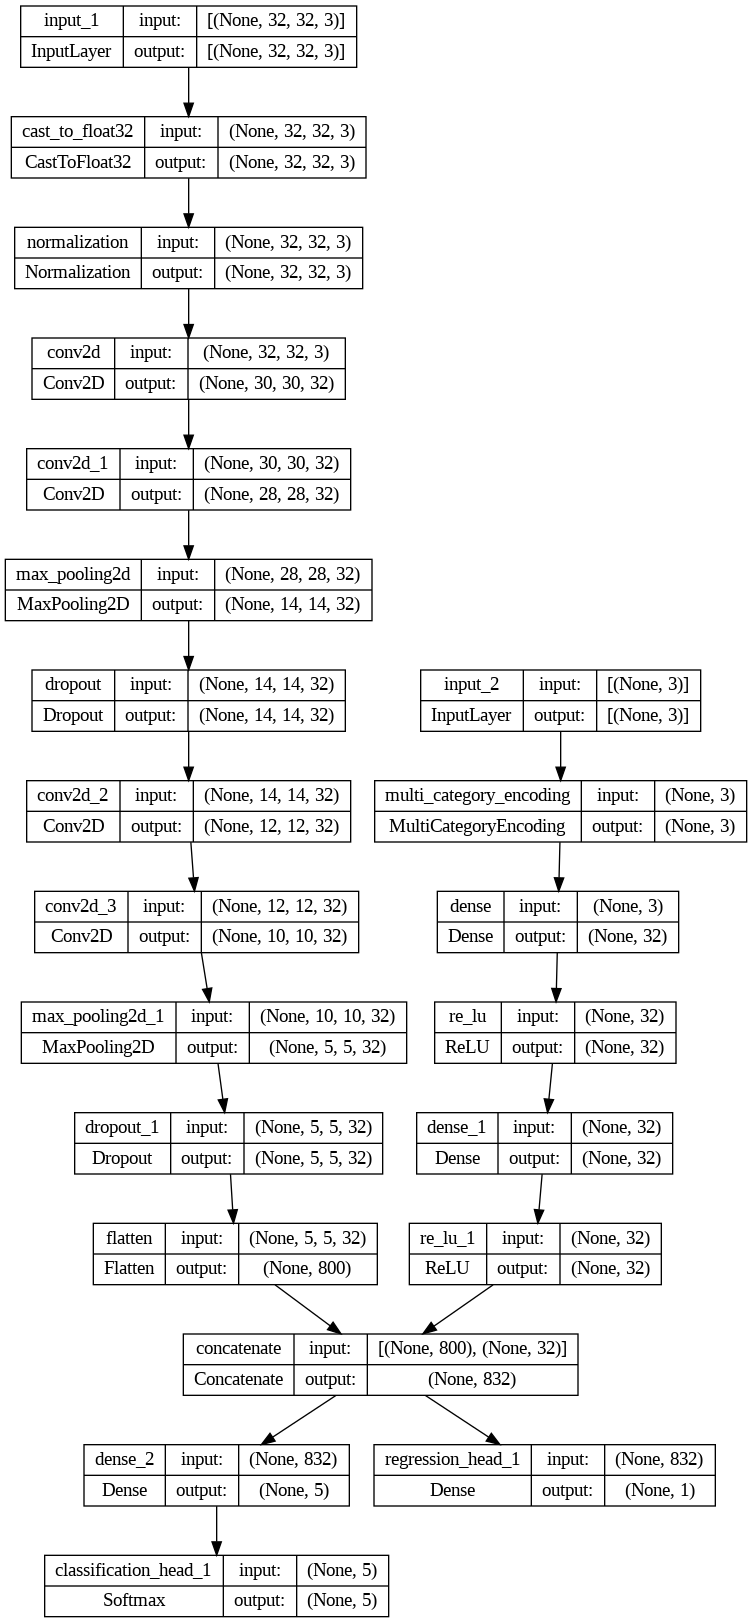

In [ ]:
tf.keras.utils.plot_model(
    best_model, show_shapes=True, expand_nested=True,
) #rankdir='LR'

### Evaluate the best model on test data

In [ ]:
total_loss, clf_loss, reg_loss, clf_acc, reg_mse = auto_model.evaluate(
    [image_test, structured_test],
    [clf_target_test, reg_target_test],
)

print("\n Total testing loss: ", total_loss)
print("Classification testing cross-entropy loss: ", clf_loss)
print("Regression testing MSE loss: ", reg_loss)
print("Classification testing accuracy: ", clf_acc)
print("Regression testing MSE: ", reg_mse)

7/7 [==============================] - 0s 19ms/step - loss: 1.7074 - classification_head_1_loss: 1.6119 - regression_head_1_loss: 0.0955 - classification_head_1_accuracy: 0.1800 - regression_head_1_mean_squared_error: 0.0955

 Total testing loss:  1.7073643207550049
Classification testing cross-entropy loss:  1.6118600368499756
Regression testing MSE loss:  0.09550421684980392
Classification testing accuracy:  0.18000000715255737
Regression testing MSE:  0.09550421684980392


# 5.5.1 Tune MLP with customized MLP block

In [1]:
!pip install -r https://raw.githubusercontent.com/datamllab/automl-in-action-notebooks/master/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 40.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.8 MB/

## Customizing a block for tuning the number of units

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def build_mlp():
  input_node = keras.Input(shape=(20,))

  output_node = layers.Dense(units=32, activation="relu")(input_node)
  output_node = layers.Dense(units=32, activation="relu")(output_node)
  output_node = layers.Dense(units=1, activation="sigmoid")(output_node)

  model = keras.Model(input_node, output_node)
  return model

In [3]:
mlp_model = build_mlp()

In [4]:
import autokeras as ak
import tensorflow as tf
from tensorflow.keras import layers

Using TensorFlow backend


In [11]:
class MLP_Block1(ak.Block):
  def build(self, hp, inputs):

    input_node = tf.nest.flatten(inputs)[0]

    units =  hp.Int(name="units", min_value=32, max_value=512, step=32)

    output_node = layers.Dense(units=units, activation="relu")(input_node)
    output_node = layers.Dense(units=units, activation="relu")(output_node)

    return output_node


In [12]:
class ML_PBlock2(ak.Block):
  def build(self, hp, inputs):

    input_node = tf.nest.flatten(inputs)[0]

    units_1 = hp.Int(name="units_1", min_value=32, max_value=512, step=32)

    units_2 = hp.Int(name="units_2", min_value=32, max_value=512, step=32)

    output_node = layers.Dense(units=units_1, activation="relu")(input_node)

    output_node = layers.Dense(units=units_2, activation="relu")(output_node)

    return output_node

## Customizing a block for tuning different types of hyperparameters

In [13]:
import autokeras as ak
import tensorflow as tf
from tensorflow.keras import layers

In [19]:
class MLPBlock1(ak.Block):
  def build(self, hp, inputs):
    output_node = tf.nest.flatten(inputs)[0]
    for i in range(hp.Choice('num_layers', [1, 2, 3])):
      output_node = layers.Dense(
          units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
          activation = "relu",

      )(output_node)
    return output_node

In [20]:
class MLPBlock2(ak.Block):
  def build(self, hp, inputs):
    output_node = tf.nest.flatten(inputs)[0]
    for i in range(hp.Choice("num_layers", [1, 2, 3])):
      output_node = layers.Dense(
          units = hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
          activation="relu",
      )(output_node)

    if hp.Boolean("dropout"):
      output_node = layers.Dropout(
          rate=hp.Float("dropout_rate", min_value=0, max_value=1)
      )(output_node)
    return output_node

## Using the customized block to create an AutoMl pipeline

In [21]:
import keras_tuner as kt

hp = kt.HyperParameters()
inputs = tf.keras.Input(shape=(20,))
MLPBlock2().build(hp, inputs)

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_3')>

In [22]:
import numpy as np

x_train = np.random.rand(100, 20)
y_train = np.random.rand(100, 1)
x_test = np.random.rand(100, 20)



In [23]:
x_train[:5]

array([[0.54636837, 0.00902299, 0.31033302, 0.13554873, 0.32685262,
        0.19350496, 0.84659359, 0.22570984, 0.52998234, 0.65299424,
        0.7736472 , 0.15463537, 0.38198724, 0.97471116, 0.51586511,
        0.37161038, 0.99168325, 0.1160604 , 0.35192614, 0.83189034],
       [0.50753317, 0.37561476, 0.70606557, 0.50011168, 0.83692515,
        0.51191335, 0.89745593, 0.02741386, 0.18735824, 0.94351183,
        0.98663285, 0.7572177 , 0.48976831, 0.36011119, 0.80718826,
        0.00530615, 0.09940271, 0.77385482, 0.61132037, 0.96770054],
       [0.78620116, 0.42403457, 0.8010579 , 0.42244025, 0.30106438,
        0.30614033, 0.51799921, 0.94029676, 0.5124448 , 0.88194086,
        0.69821965, 0.46138906, 0.12597416, 0.63727011, 0.88705893,
        0.88823679, 0.10509241, 0.32471761, 0.96365425, 0.74190541],
       [0.99706229, 0.93724417, 0.83008507, 0.10651404, 0.86588605,
        0.31050968, 0.17660098, 0.832275  , 0.92069378, 0.36225109,
        0.95941134, 0.02631723, 0.1192644 , 0

In [24]:
input_node = ak.StructuredDataInput()
output_node = MLPBlock2()(input_node)
output_node = ak.RegressionHead()(output_node)
auto_model = ak.AutoModel(input_node, output_node, max_trials=3, overwrite=True)
auto_model.fit(x_train, y_train, epochs=1)

Trial 3 Complete [00h 00m 01s]
val_loss: 0.10614059865474701

Best val_loss So Far: 0.10614059865474701
Total elapsed time: 00h 00m 09s
4/4 [==============================] - 0s 5ms/step - loss: 0.1753 - mean_squared_error: 0.1753


In [25]:
auto_model.predict(x_test).shape

4/4 [==============================] - 0s 4ms/step


(100, 1)

In [26]:
auto_model.tuner.search_space_summary()

Search space summary
Default search space size: 6
mlp_block2_2/num_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
mlp_block2_2/units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
mlp_block2_2/dropout (Boolean)
{'default': False, 'conditions': []}
regression_head_1/dropout (Choice)
{'default': 0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'adam_weight_decay'], 'ordered': False}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001, 2e-05, 1e-05], 'ordered': True}


# 5.5.2 Design HyperBlock for model selection

In [27]:
!pip install -r https://raw.githubusercontent.com/datamllab/automl-in-action-notebooks/master/requirements.txt


In [29]:
import tensorflow as tf
import numpy as np

model = tf.keras.applications.DenseNet121(include_top=False, weights=None)
print(model(np.random.rand(100, 32, 32, 3)).shape)

(100, 1, 1, 1024)


## Build an AutoML block to select among different DenseNet models

In [30]:
import autokeras as ak
import tensorflow as tf

In [31]:
class DenseNetBlock(ak.Block):
  def build(self, hp, inputs):
    version = hp.Choice("version", ["DenseNet121", "DenseNet169", "DenseNet201"])
    if version == "DenseNet121":
      dense_net_func = tf.keras.applications.DenseNet121
    elif version == "DenseNet169":
      dense_net_func = tf.keras.applications.DenseNet169
    elif version == "DenseNet201":
      dense_net_func = tf.keras.applications.DenseNet201
    return dense_net_func(include_top=False, weights=None)(inputs)


## Build a HyperBlock to select between DenseNet and ResNet

In [33]:
# Model selection block
class SelectionBlock(ak.Block):
  def build(self, hp, inputs):
    if hp.Choice("model_type", ["densenet", "resnet"]) == "densenet":
      outputs = DenseNetBlock().build(hp, inputs)
    else:
      outputs = ak.ResNetBlock().build(hp, inputs)
    return outputs

In [34]:
# Model selection block with conditional scope
class SelectionBlock(ak.Block):
  def build(self, hp, inputs):
    if hp.Choice("model_type", ["densenet", "resnet"]) == "densenet":
      with hp.conditional_scope("model_type", ["densenet"]):
        outputs = DenseNetBlock().build(hp, inputs)

    else:
      with hp.conditional_scope("model_type", ["resnet"]):
        outputs = ak.ResNetBlock().build(np, inputs)

    return outputs


## Build model with the customized HyperBlock and conduct search

In [36]:
input_node = ak.ImageInput()
output_node = SelectionBlock()(input_node)
output_node = ak.ClassificationHead()(output_node)
auto_model = ak.AutoModel(input_node, output_node, max_trials=5, overwrite=True)

from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
auto_model.fit(x_train[:100], y_train[:100], epochs=1)

Trial 5 Complete [00h 00m 23s]
val_loss: 3.1657543182373047

Best val_loss So Far: 2.853034734725952
Total elapsed time: 00h 02m 34s
4/4 [==============================] - 15s 458ms/step - loss: 2.7618 - accuracy: 0.0900


In [38]:
auto_model.tuner.search_space_summary()

Search space summary
Default search space size: 6
selection_block_2/model_type (Choice)
{'default': 'densenet', 'conditions': [], 'values': ['densenet', 'resnet'], 'ordered': False}
selection_block_2/dense_net_block_1/version (Choice)
{'default': 'DenseNet121', 'conditions': [{'class_name': 'Parent', 'config': {'name': 'selection_block_2/model_type', 'values': ['densenet']}}], 'values': ['DenseNet121', 'DenseNet169', 'DenseNet201'], 'ordered': False}
classification_head_2/spatial_reduction_1/reduction_type (Choice)
{'default': 'flatten', 'conditions': [], 'values': ['flatten', 'global_max', 'global_avg'], 'ordered': False}
classification_head_2/dropout (Choice)
{'default': 0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'adam_weight_decay'], 'ordered': False}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001, 2e-05, 1e-05], 'ordered': True}
